<a href="https://colab.research.google.com/github/mertent/ml-2/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import matplotlib as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [25, 15]

# Genre selection

In [2]:
from google.colab import auth

import pandas as pd
import numpy as np

project_id = 'ml-project-309813'
bucket_name = 'ml_sprint2_mp3'

def init_cloud():
  auth.authenticate_user()

  !gcloud config set project {project_id}

def download_from_cloud(filepath, unzip = False):
  init_cloud()
  filename = filepath.split('/')[-1]
  !gsutil cp gs://{bucket_name}/$filepath .
  if unzip:
    !unzip -q $filename
    !rm $filename

def upload_to_cloud(filename, zip = False):
  init_cloud()
  if zip:
    zipname = '{}.zip'.format(filename)
    !zip $zipname $filename
    !gsutil cp $zipname gs://{bucket_name}/
    !rm $zipname
  else:
    !gsutil cp $filename gs://{bucket_name}/

In [3]:
download_from_cloud('tracks_with_sample.pkl.zip', unzip = True)

Updated property [core/project].
Copying gs://ml_sprint2_mp3/tracks_with_sample.pkl.zip...
/ [1 files][  6.8 MiB/  6.8 MiB]                                                
Operation completed over 1 objects/6.8 MiB.                                      
replace tracks_with_sample.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
tracks = pd.read_pickle('tracks_with_sample.pkl')

In [5]:
genres = ['sad', 'happy', 'heavy-metal', 'k-pop', 'blues', 'alt-rock', 'classical', 'jazz', 'disco', 'drum-and-bass']

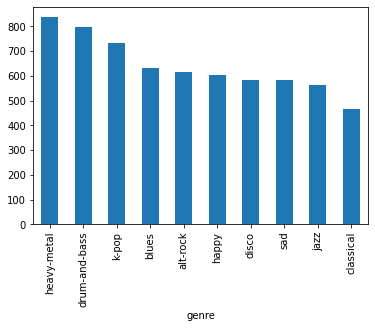

In [6]:
tracks[tracks['genre'].isin(genres)].value_counts('genre').plot(kind = 'bar')

# Data preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [8]:
download_from_cloud('data.csv.zip', unzip = True)

Updated property [core/project].
Copying gs://ml_sprint2_mp3/data.csv.zip...
/ [1 files][ 14.7 MiB/ 14.7 MiB]                                                
Operation completed over 1 objects/14.7 MiB.                                     
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [9]:
csv = pd.read_csv('data.csv').drop('instrumentalness', axis = 1)
csv.head()


,track_id,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,7m7SLo5HUI0DyDXzMh8wNv,0.461419,0.349618,2747.332185,2554.214631,5601.416129,0.140665,56.223515,73.457298,-18.041945,26.415985,1.756558,9.851189,0.590065,7.277120,3.868406,13.852572,-2.941686,5.088948,-4.421315,2.747003,-3.081998,3.358888,-3.392253,3.239243,3.219959,4.650892
1,6d67dxOSfGKh5PdajyLSWm,0.483012,0.265985,2112.421234,2445.767968,4749.262949,0.059092,-78.577553,97.260010,15.902855,32.797787,0.600500,13.400225,-2.983642,9.846685,-8.518023,10.379026,-4.649569,4.574261,-2.577501,1.222419,3.834130,6.670552,1.522592,8.789327,3.231066,2.853462
2,6226wcHJbifKCqhN8ZCkMg,0.364345,0.188669,2068.356307,2349.537868,4540.447545,0.069081,-114.790535,96.585663,17.304708,30.451933,-4.400069,14.700328,-9.050969,2.998199,-5.182761,2.615429,-10.854939,0.760484,-3.946095,-0.060809,-6.774857,-1.057367,-4.474327,-0.674645,-7.189997,2.244162
3,2G4iTsdENLdVI8mWxZ6l6n,0.426456,0.225496,1913.436591,2018.147118,3826.718527,0.096819,-26.478724,117.908524,-29.189484,32.336597,2.403701,5.549382,-3.379838,13.127804,-3.544428,7.435021,-5.242411,6.120144,-3.433726,0.829871,-4.526956,2.918036,-4.669353,-0.692641,-2.682045,0.892190
4,2btKz4s1XrMn5VHe7xZJpi,0.396857,0.315556,2272.510277,2467.051733,4823.704165,0.086627,-64.377640,82.928268,-10.065195,21.885105,0.378192,2.787563,9.316062,-4.451181,2.910890,1.826487,2.448398,8.532267,-5.928687,13.032363,-6.220285,4.767183,-3.243019,3.177322,-7.358551,-0.178495


In [10]:
genre = pd.read_pickle('tracks_with_sample.pkl')[['track_id', 'genre']]
genre = genre[genre['genre'].isin(genres)]
genre.head()

,track_id,genre
2467967,4Q8oSQuKKsD7TPOamqe9PD,blues
2467969,4ZuteqxaqzNneO9qXToPBf,blues
2720911,2JLAr5J7fP4IsRtx9cLkWN,jazz
2720913,3DIlFc3fn9GBy8KhJdSQAb,jazz
2720915,0vak1oPiTnzC32ydpB9pBD,jazz


In [11]:
data = csv.merge(genre, how = 'right', on = 'track_id')
data.drop('track_id', axis = 1, inplace = True)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,genre
0,0.243430,0.104506,1829.611181,1936.156983,3553.403513,0.099078,-159.782944,109.528542,-26.547613,16.328909,-8.790853,3.785009,-8.694206,-2.677922,-14.511781,-6.773925,-8.081242,-6.631172,-14.921545,-3.785332,-9.210418,-3.357559,-4.879929,1.076374,-9.525467,-11.107369,blues
1,0.268396,0.129339,1860.682326,2041.435587,3869.226603,0.086167,-135.968094,104.179352,-20.840080,32.833786,-3.024058,9.973715,-11.523556,1.395892,-10.340799,-0.803586,-8.905837,-10.700939,-12.334221,-2.153023,-6.464903,-3.050731,-12.755614,0.326999,-5.610766,-5.840787,blues
2,0.245805,0.080863,656.938001,641.831179,1036.285400,0.046268,-308.233215,199.661728,10.691067,-10.488408,8.946229,-8.338365,-15.073838,-10.456519,-9.444200,-8.608827,-6.823158,-3.909892,-1.406227,-1.713691,-4.447212,-6.944537,-4.257952,0.356190,-0.677116,-2.676275,jazz
3,0.324553,0.276939,1225.493974,1549.801883,2518.318105,0.050359,-108.475716,151.296997,-8.459536,54.363319,0.505408,12.177233,-5.776083,-1.061937,-5.680620,-2.491732,-4.425607,0.148907,-0.760442,-6.927999,-4.028503,1.148414,-2.570627,0.630785,-1.806599,3.001308,jazz
4,0.371651,0.076296,1002.920863,1807.077989,1769.647633,0.026803,-293.166504,142.873169,43.260677,25.694273,5.471840,15.822524,-0.577713,0.897702,-4.822966,7.010815,1.959140,0.615736,-0.206565,-0.231033,-4.657780,-1.511053,-4.188111,0.357045,-3.720739,-0.517207,jazz


In [12]:
x = data.drop('genre', axis = 1)
y = data['genre']
print(x.shape)
print(y.shape)

(6413, 26)
(6413,)


In [13]:
x.describe()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000
mean,0.420862,0.268223,2396.333550,2427.188214,5089.357850,0.101549,-53.030319,90.777286,2.780759,24.207722,3.491852,10.800727,-0.588414,7.286145,-2.012250,6.067923,-2.464605,4.477604,-2.565899,2.528663,-2.790235,2.731884,-3.463526,2.640156,-2.603370,1.873867
std,0.095136,0.097614,765.278788,586.597936,1711.883368,0.039092,104.284384,37.486968,20.843685,12.345948,7.406664,7.697932,5.892432,6.678777,5.680268,5.986683,4.737818,5.230465,4.093622,4.582289,3.896650,4.213768,3.693527,3.965869,3.384409,3.935430
min,0.165254,0.007563,231.183518,316.714776,326.706358,0.010793,-585.002808,3.476090,-69.733444,-30.962936,-35.880371,-33.100578,-36.949379,-22.956245,-43.634136,-26.318457,-27.670605,-25.623213,-24.807171,-20.907988,-22.170406,-19.272221,-26.649666,-17.049248,-22.560471,-17.548855
25%,0.362817,0.209040,2042.729107,2265.738800,4351.173689,0.073772,-79.889923,67.197472,-10.699335,16.817751,-1.029763,6.851255,-4.016921,4.254329,-5.220384,3.463208,-5.110904,2.007865,-4.972237,0.073005,-5.178960,0.629079,-5.666915,0.542987,-4.638258,-0.257288
50%,0.425610,0.275247,2521.326219,2543.547859,5367.659209,0.102531,-22.077248,82.384880,0.675239,23.835888,3.400885,11.457628,-0.287582,8.381601,-1.416137,6.943162,-2.039488,5.237724,-2.352681,2.978090,-2.700878,3.184807,-3.384366,2.980435,-2.498003,2.191798
75%,0.483800,0.332465,2891.070174,2794.215381,6260.787142,0.127779,14.969823,104.077507,13.211217,31.801117,7.848687,15.603254,3.246293,11.597939,1.756363,9.828288,0.678566,7.864748,0.024997,5.565536,-0.291290,5.450910,-1.090914,5.233492,-0.489888,4.369772
max,0.708968,0.720604,4597.020988,3550.799933,8590.389722,0.301437,110.011299,250.786667,99.935532,73.756668,52.237282,52.119305,30.414879,39.137123,18.822409,27.092594,17.549774,20.621292,16.224115,21.061314,25.728470,21.508389,19.006201,27.985247,22.486940,21.133535


In [14]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.15)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5451, 26)
(5451,)
(962, 26)
(962,)


# Training the model

In [16]:
from sklearn import svm
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

### With Linear SVC

In [17]:
clf = svm.LinearSVC()
clf.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [18]:
test_predictions = clf.predict(X_test)
print(accuracy_score(Y_test, test_predictions))

0.6133056133056133


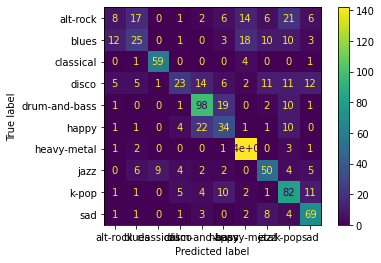

In [19]:
plot_confusion_matrix(clf, X_test, Y_test)

### With gridsearch and PCA

In [20]:
pca = PCA(n_components=15, whiten = True)
svm = svm.SVC(kernel = 'linear')

model = make_pipeline(pca, svm)

In [23]:
param_grid = [
              {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear'], 'svc__class_weight': [None, 'balanced'], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]},
              {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 'svc__kernel': ['rbf'], 'svc__class_weight': [None, 'balanced'], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]},
              {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear'], 'svc__class_weight': [None, 'balanced'], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]},
              {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 'svc__kernel': ['rbf'], 'svc__class_weight': [None, 'balanced'], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]} 
]

param_grid1 = [
              {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear'], 'svc__class_weight': [None, 'balanced'], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]},
              {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 'svc__kernel': ['rbf'], 'svc__class_weight': [None, 'balanced'], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]} 
]

param_grid2 = [
              {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 'svc__kernel': ['poly'], 'svc__class_weight': [None, 'balanced'], 'svc__degree': [2, 3, 4, 5], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]},
              {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 'svc__kernel': ['sigmoid'], 'svc__class_weight': [None, 'balanced'], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]}
]

param_grid3 = [
              {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear'], 'pca__n_components': [5, 15, 26], 'pca__whiten': [True, False]},
              {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 'svc__kernel': ['rbf'], 'pca__n_components': [5, 15, 26], 'pca__whiten': [True, False]} 
]

param_grid4 = [
              {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear'], 'pca__n_components': [5, 26]},
              {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 'svc__kernel': ['rbf'], 'pca__n_components': [5, 26]} 
]

In [24]:
search = GridSearchCV(model, param_grid = param_grid4)
search.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=15, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='linear', max_iter=-1,...
                                            tol=0.001, verbose=False))],
                                verb

In [27]:
print(search.best_params_)

{'pca__n_components': 26, 'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [28]:
clf = search.best_estimator_
test_predictions = clf.predict(X_test)
print(accuracy_score(Y_test, test_predictions))

0.6860706860706861


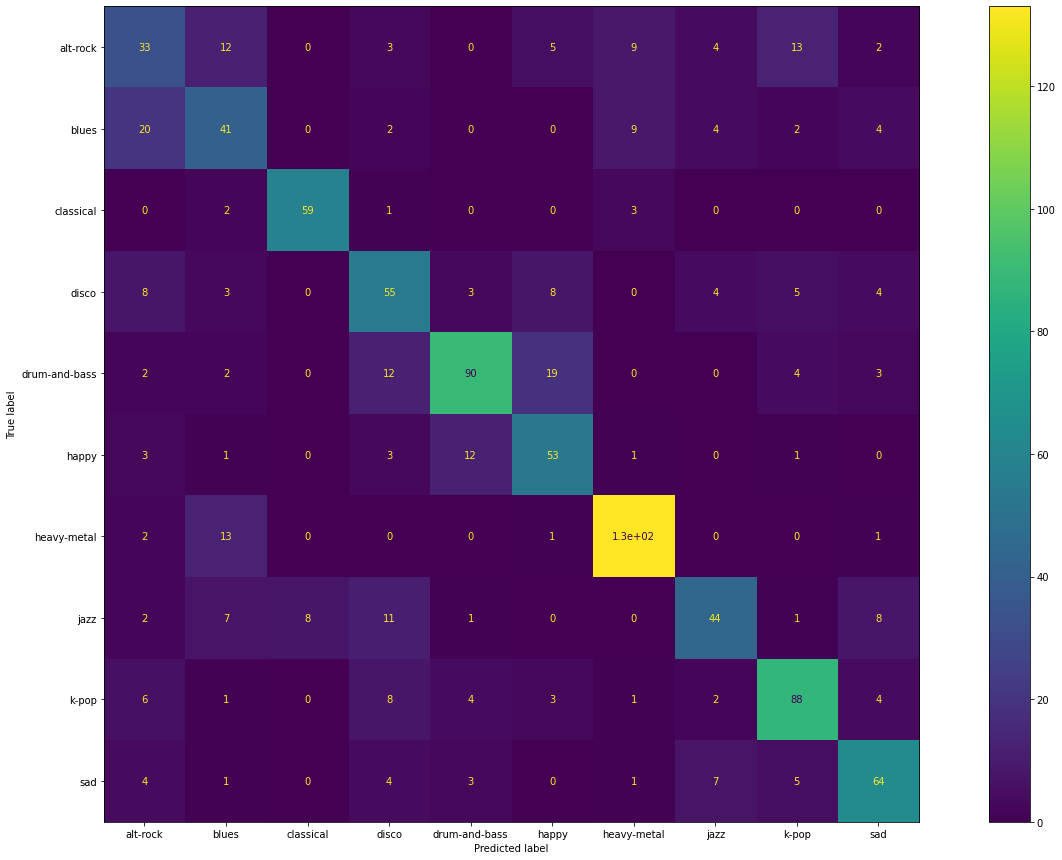

In [31]:
plot_confusion_matrix(clf, X_test, Y_test)